Generate the relevant vizualizations:

* Basic level: NEXT vs Salmon vs random

Why does Salmon do so much better?

* Embedding? Perform the same search use NEXT/Salmon embedding code.
* Searches? Use same backend, different search params.
    * → also show Salmon has effective engineering
    
Why is Salmon's search so much better?

* How does round robin affect different search lengths?
* How does top-k affect long search?

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from viz import lineplot
save_kwargs = dict(dpi=300, bbox_inches="tight", transparent=True)

In [4]:
nm = "CKL"
ACC_YLIM = (0.80, 0.835)
ANS_XLIM = (0, 25_000)

df = pd.read_csv("_viz_data.csv")
print(len(df))
df = df[df.meta__noise_model == nm].copy()
print(len(df))

idx = df.meta__sampling == "random"
random = df[idx].copy()
active = df[~idx].copy()
df.columns

1710
648


Index(['Unnamed: 0', 'accuracy', 'nn_diff_median', 'nn_diff_mean', 'nn_acc',
       'avg_items_closer_than_NN', 'nn_diff_p99', 'nn_diff_p98', 'nn_diff_p95',
       'nn_diff_p90', 'nn_diff_p80', 'nn_diff_p70', 'nn_diff_p60',
       'nn_diff_p50', 'nn_diff_p40', 'nn_diff_p30', 'nn_diff_p20',
       'nn_diff_p10', 'nn_diff_p5', 'nn_diff_p2', 'nn_diff_p1',
       'embedding_error', 'embedding_rel_error', 'procrustes_disparity',
       'nn_acc_radius_0', 'nn_acc_radius_1', 'nn_acc_radius_2',
       'nn_acc_radius_3', 'nn_acc_radius_4', 'nn_acc_radius_5',
       'nn_acc_radius_6', 'nn_acc_radius_7', 'nn_acc_radius_8',
       'nn_acc_radius_9', 'nn_acc_radius_10', 'nn_acc_radius_11',
       'nn_acc_radius_12', 'nn_acc_radius_13', 'nn_acc_radius_14',
       'nn_acc_radius_15', 'nn_acc_radius_16', 'nn_acc_radius_17',
       'nn_acc_radius_18', 'nn_acc_radius_19', 'nn_acc_radius_20',
       'nn_acc_radius_21', 'nn_acc_radius_22', 'nn_acc_radius_23',
       'nn_acc_radius_24', 'nn_acc_radius_25',

In [5]:
df.meta__n

6       90
9       90
10      90
11      90
12      90
        ..
1705    90
1706    90
1707    90
1708    90
1709    90
Name: meta__n, Length: 648, dtype: int64

In [11]:
active["fname"] = active["meta__meta__fname"].apply(lambda x: x.split("/")[-1].replace("_responses.csv.zip", ""))
active["meta__system"] = active["meta__meta__fname"].apply(lambda x: "next" if "next" in x else "salmon")
print(active.meta__meta__fname.unique())

rate1 = active["fname"].apply(lambda x: "TSTE" in x and "-1" == x[-2:])
active.loc[rate1, "meta__rate"] = 1

# proxy for rate=1. Filenames like 'rate=0.5_responses.msgpack' were submitted at 0.5 resposnes/sec
rate1arr = active["fname"].apply(lambda x: "n_top" in x)
active.loc[rate1arr, "meta__rate"] = 1

# defaults
active["meta__n_search"] = 90 * 89 * (88 // 2)
active["meta__n_top"] = 3
_cleaned_fnames = active["fname"].apply(lambda x: x.replace("ARR-", "").replace("-1_responses.csv.zip", "")).replace("TSTE-", "")
active.loc[rate1arr, "meta__n_search"] = _cleaned_fnames[rate1arr].apply(lambda x: int(x.split("-")[0].split("=")[1]))
active.loc[rate1arr, "meta__n_top"] = _cleaned_fnames[rate1arr].apply(lambda x: int(x.split("-")[1].split("=")[1]))

active["meta__search"] = ""
active.loc[rate1arr, "meta__search"] = "arr"

salmon_tste = active.meta__meta__fname.apply(lambda x: "TSTE-" in x and "salmon" in x)

_cleaned_fnames2 = active["fname"].apply(lambda x: x.replace("TSTE-", "").replace("-1_responses.csv.zip", "").replace("ARR-", ""))
_cleaned_fnames2 = _cleaned_fnames2.str.replace("-1", "")
active.loc[salmon_tste, "meta__n_search"] = _cleaned_fnames2[salmon_tste].apply(lambda x: int(x.split("=")[1]))
assert active.meta__rate.isnull().sum() == 0

['salmon/io/2021-05-26-search/TSTE-n_search=30-1_responses.csv.zip'
 'salmon/io/2021-05-26-search/TSTE-n_search=3000-1_responses.csv.zip'
 'salmon/io/2021-05-26-search/TSTE-n_search=300000-1_responses.csv.zip'
 'salmon/io/2021-05-26-search/TSTE-n_search=300-1_responses.csv.zip'
 'salmon/io/2021-05-26-search/TSTE-n_search=30000-1_responses.csv.zip'
 'salmon/io/2021-05-26-search/TSTE-n_search=10000-1_responses.csv.zip'
 'salmon/io/2021-05-26-search/TSTE-n_search=1000-1_responses.csv.zip'
 'salmon/io/2021-05-25/ARR-10_responses.csv.zip'
 'next/io/2021-05-24/rate=1_responses.msgpack'
 'salmon/io/2021-05-25/ARR-5_responses.csv.zip'
 'next/io/2021-05-24/rate=0.5_responses.msgpack'
 'next/io/2021-05-24/rate=2_responses.msgpack'
 'salmon/io/2021-05-25/ARR-2_responses.csv.zip'
 'salmon/io/2021-05-25/ARR-1_responses.csv.zip'
 'salmon/io/2021-05-26-search/TSTE-n_search=100000-1_responses.csv.zip'
 'next/io/2021-05-24/rate=5_responses.msgpack'
 'salmon/io/2021-05-25/ARR-0.5_responses.csv.zip'
 'sa

# Straight comparison

In [12]:
def _fmt1(ax):
    ax.set_ylim(*ACC_YLIM)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x * 1000) / 10}%"))
    ax.set_title("Test set accuracy")
    
def _fmt2(ax):
    ax.set_ylim(0, 6)
    ax.set_title("Avg. # of items\ncloser than true NN")
    
def _fmt(axs):
    assert len(axs) == 2
    _fmt1(axs[0])
    _fmt2(axs[1])
    for ax in axs:
        ax.set_xlim(*ANS_XLIM)
        ax.grid(alpha=0.5)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x // 1000)}"))
        ax.set_xlabel("Num. observed responses\n(thousands)")

['salmon/io/2021-05-25/ARR-1_responses.csv.zip'
 'ARR-n_search=352440-n_top=3-1_responses.csv.zip']
17
14


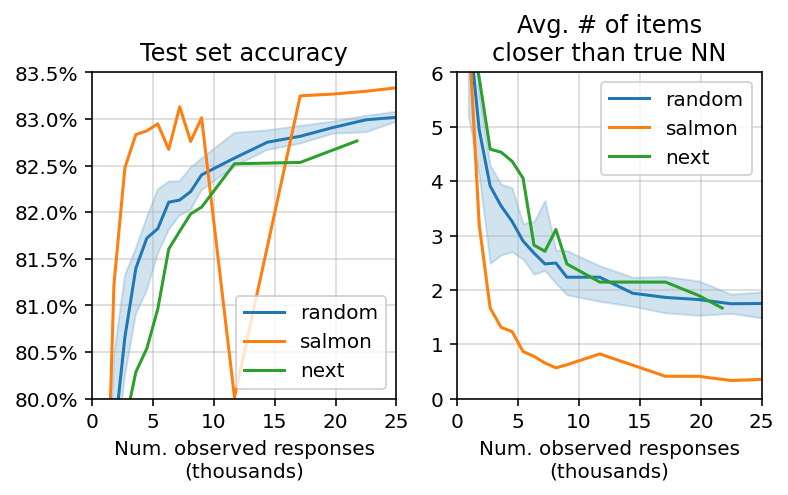

In [15]:
salmon = (active.meta__rate == 1) & (active.meta__system == "salmon")
salmon &= (active.meta__n_search == 352440) & (active.meta__n_top == 3)
salmon &= active.meta__sampling == "salmon"
print(active[salmon].meta__meta__fname.unique())
salmon &= active.meta__meta__fname.apply(lambda x: "n_search=352440-n_top=" in x)  # get one run of Salmon
bad = (14_000 <= active.meta__len_X_train) & (active.meta__len_X_train <= 15_000)
salmon = (salmon) & (~bad)
print(salmon.sum())

NEXT = (active.meta__rate == 1) & (active.meta__system == "next")
print(NEXT.sum())

show = pd.concat((random, active[salmon], active[NEXT]))

w = 3
fig, axs = plt.subplots(ncols=2, figsize=(2 * w, w))

kwargs = dict(
    data=show,
    x="meta__len_X_train",
    hue="meta__sampling",
    hue_order=["random", "salmon", "next"],
    style="-",
    ci=1,
)
ax = lineplot(y="accuracy", ax=axs[0], **kwargs)
ax = lineplot(y="nn_diff_mean", ax=axs[1], **kwargs)
_fmt(axs)

plt.savefig("figs3/direct-comparison.png", **save_kwargs)

# Why is Salmon's search better?

Salmon's search is better. Is it because of the search or the embedding?

**Messages:**

* NEXT and Salmon peform the same for similar searches (so backend likely the same quality for this load)
* Longer searches help (but they present some problems).

## Same search, different embedding

18
14


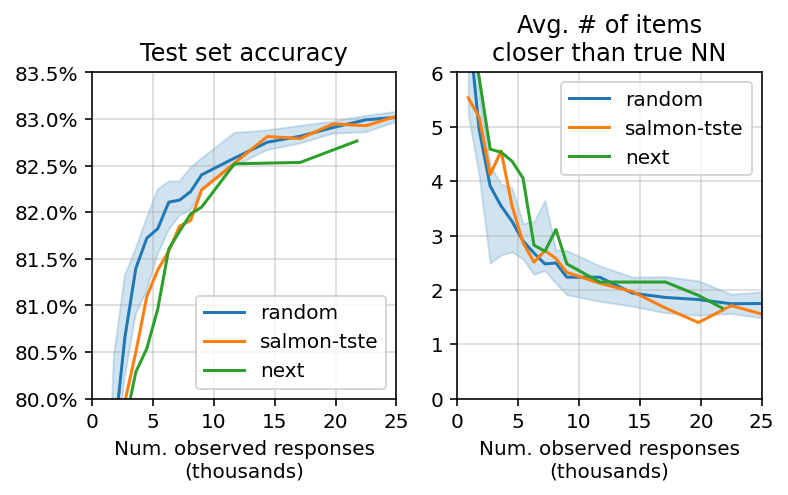

In [6]:
salmon = (active.meta__sampling == "salmon-tste")
salmon &= (active.meta__n_search == 100)
print(salmon.sum())

NEXT = (active.meta__rate == 1) & (active.meta__system == "next")
print(NEXT.sum())

show = pd.concat((random, active[salmon], active[NEXT]))

w = 3
fig, axs = plt.subplots(ncols=2, figsize=(2 * w, w))

kwargs = dict(
    data=show,
    x="meta__len_X_train",
    hue="meta__sampling",
    hue_order=["random", "salmon-tste", "next"],
    style="-",
    ci=1,
)
ax = lineplot(y="accuracy", ax=axs[0], **kwargs)
ax = lineplot(y="nn_diff_mean", ax=axs[1], **kwargs)
_fmt(axs)
fig.savefig("figs3/same-search-diff-embedding.png", **save_kwargs)

## Different searches, same embedding

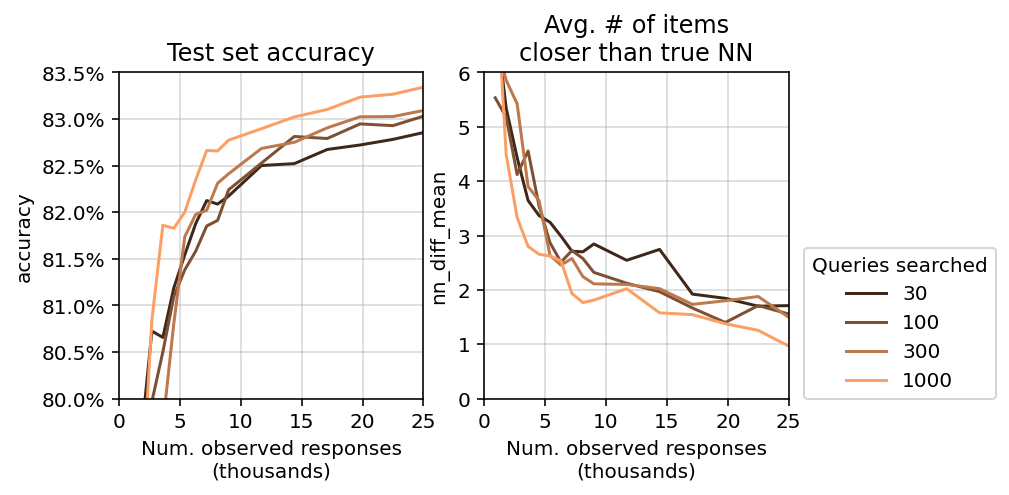

In [7]:
salmon_tste = active[active.meta__sampling == "salmon-tste"]

w = 3
fig, axs = plt.subplots(ncols=2, figsize=(2 * w, w))

show = salmon_tste[salmon_tste.meta__n_search <= 30_000].copy()
show["meta__n_search__str"] = show["meta__n_search"].astype(str)
searches = [30, 100, 300, 1000, 3000, 10_000, 30_000]
assert set(show["meta__n_search"]) == set(searches)
searches = [30, 100, 300, 1000]#, 3_000]#, 10_000]

kwargs = dict(
    data=show,
    x="meta__len_X_train",
    hue="meta__n_search__str",
    hue_order=list(map(str, searches)),
    palette="copper",
    ci=None,
)
ax = sns.lineplot(y="accuracy", ax=axs[0], **kwargs)
ax.legend_.remove()

ax = sns.lineplot(y="nn_diff_mean", ax=axs[1], **kwargs)
ax.legend(loc=(1.05, 0), title="Queries searched")

_fmt(axs)
fig.savefig("figs3/search1.png", **save_kwargs)

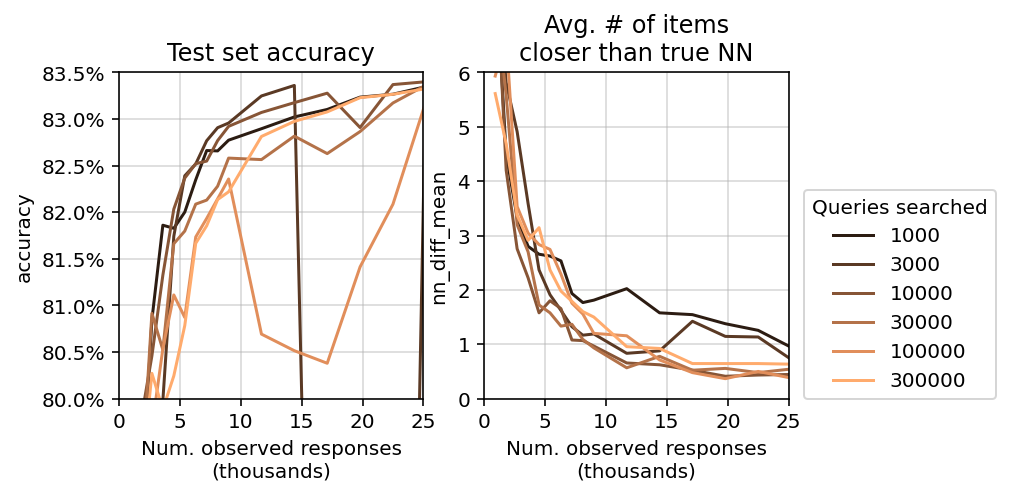

In [8]:
salmon_tste = active[active.meta__sampling == "salmon-tste"]

w = 3
fig, axs = plt.subplots(ncols=2, figsize=(2 * w, w))

show = salmon_tste.copy()
show["meta__n_search__str"] = show["meta__n_search"].astype(str)
# assert set(show["meta__n_search"]) == set(searches)
searches = [1000, 3_000, 10_000, 30_000, 100_000, 300_000]
# searches = [3_000, 10_000, 30_000]

kwargs = dict(
    data=show,
    x="meta__len_X_train",
    hue="meta__n_search__str",
    hue_order=list(map(str, searches)),
    palette="copper",
    ci=None,
)
ax = sns.lineplot(y="accuracy", ax=axs[0], **kwargs)
ax.legend_.remove()

ax = sns.lineplot(y="nn_diff_mean", ax=axs[1], **kwargs)
ax.legend(loc=(1.05, 0), title="Queries searched")
_fmt(axs)
# axs[0].set_xlim(14_000, 20_000)
# axs[0].set_ylim(0.6, 0.84)
# fig.savefig("figs3/search2.png", **save_kwargs)

TODO: plots of query uniformity (in a separate notebook)

# Salmon engineering

Salmon enforces some query diversity. But how do the choices affect performance?

## Round robin

In [9]:
import numpy as np

In [10]:
def _plot_tste_perf(tste: pd.DataFrame, ax, y="accuracy", linewidth=3, label="{est}(TSTE)"):
    est = "max" if "acc" in y else "min"
    sns.lineplot(
        data=tste,
        x="meta__len_X_train",
        y=y,
        estimator=est,
        ci=None,
        ax=ax,
        color="C2",
        linewidth=linewidth,
        label=label.format(est=est),
    )
SALMON_TSTE = active[(active.meta__sampling == "salmon-tste")]

[352440  30000   3000  10000   1000 100000]


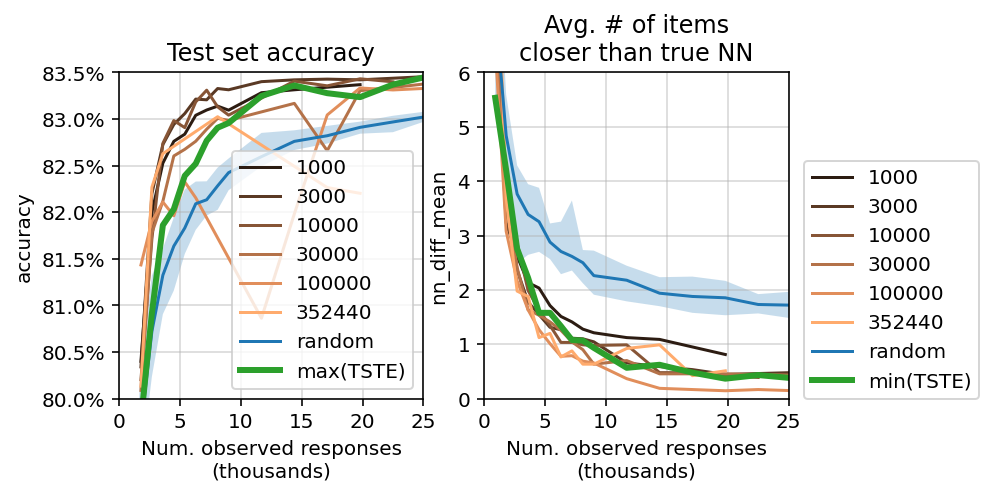

In [11]:
show = active[(active.meta__search == "arr") & (active.meta__n_top == 1)].copy()
show["meta__n_search__str"] = show["meta__n_search"].astype(str)

w = 3
fig, axs = plt.subplots(figsize=(2 * w, w), ncols=2)
searches = [1000, 3_000, 10_000]#, 30_000, 100_000, 352440]
# searches = [1000, 3_000, 10_000, 30_000, 100_000]#, 352440]
# searches = [1000, 3_000, 10_000, 30_000, 100_000, 352440]
searches = [1000, 3_000, 10_000, 30_000]#, 100_000]#, 352440]
# searches = [10_000, 30_000, 100_000, 352440]
searches = [1000, 3_000, 10_000, 30_000, 100_000, 352440]
print(show["meta__n_search"].unique())
# searches = [1000, 10_000, 100_000]
# searches = [3000, 30_000, 352440]
kwargs = dict(
    x="meta__len_X_train",
    hue="meta__n_search__str",
    hue_order=list(map(str, searches)),
    palette="copper",
    ci=None,
)
ax = sns.lineplot(data=show[show.accuracy >= 0.8], y="accuracy", ax=axs[0], **kwargs)
ax.legend_.remove()
from copy import deepcopy

def _plot_perf(random: pd.DataFrame, ax, kwargs, y="accuracy"):
    r_kwargs = deepcopy(kwargs)
    for k in ["hue", "hue_order"]:
        r_kwargs.pop(k, "")

    r_kwargs["ci"] = None
    
    _kwargs = dict(index="meta__len_X_train", values=y)
    _middle = random.pivot_table(**_kwargs, aggfunc="mean")
    _lower = random.pivot_table(**_kwargs, aggfunc="min")
    _upper = random.pivot_table(**_kwargs, aggfunc="max")
    sns.lineplot(data=random, y=y, ax=ax, color="C0", label="random", **r_kwargs)
    ax.plot()
    ax.fill_between(
        _middle.index,
        _lower.to_numpy().flatten(),
        _upper.to_numpy().flatten(),
        alpha=0.25,
    )
_plot_perf(random, ax, kwargs, y="accuracy")
_plot_tste_perf(SALMON_TSTE, ax, y="accuracy")

ax = sns.lineplot(data=show, y="nn_diff_mean", ax=axs[1], **kwargs)
_plot_perf(random, ax, kwargs, y="nn_diff_mean")
_plot_tste_perf(SALMON_TSTE, ax, y="nn_diff_mean")
ax.legend(loc=(1.05, 0))
_fmt(axs)
# axs[1].set_ylim(0, 3)
# ax.set_ylim(1, 3)
fig.savefig("figs3/arr-search.png", **save_kwargs)

In [12]:
active.meta__n_search.unique()

array([    30,   3000, 300000,    300,  30000,  10000,   1000, 352440,
       100000,    100])

255


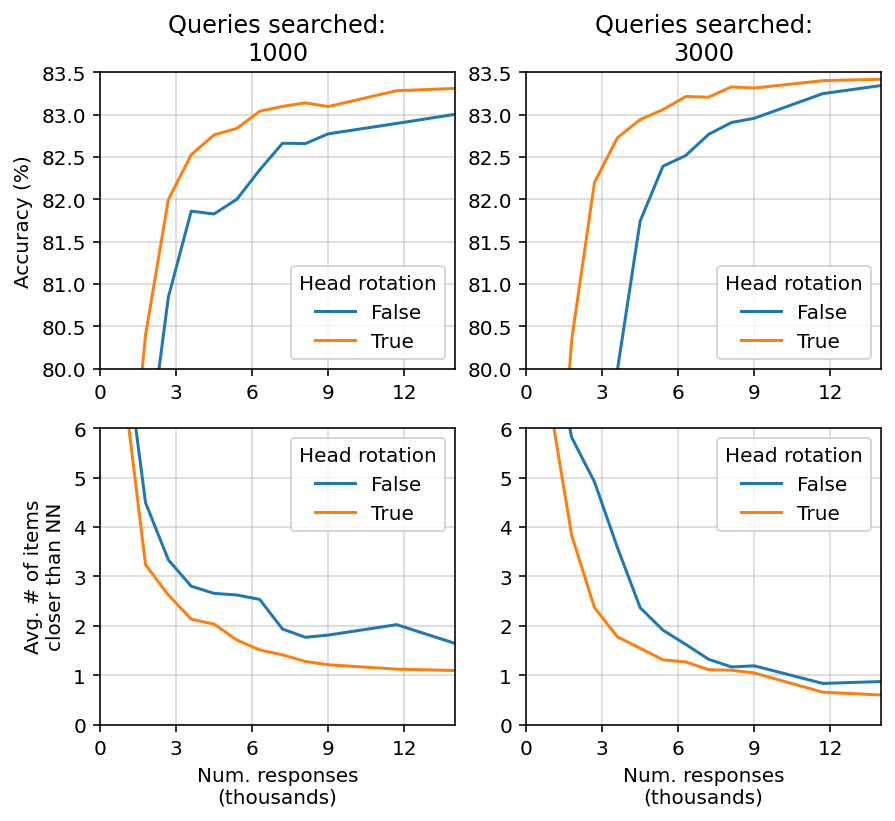

In [13]:
_salmon_tste = salmon_tste.copy()
_salmon_tste["meta__search"] = "salmon-tste"

idx = (active.meta__search == "arr") & (active.meta__n_top == 1)
show = pd.concat((active[idx].copy(), _salmon_tste)).copy()
print(len(show))

show = show[(show.meta__n_search >= 1e3) & (show.meta__n_search <= 3e3)].copy()
names = {"arr": "True", "salmon-tste": "False"}
show["Head rotation"] = show.meta__search.apply(names.get)
# show["Search"] = show.meta__

w = 2.5
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(2 * 1.4 * w, 2 * 1.2 * w))
searches = list(sorted(show.meta__n_search.unique()))
for row, y in zip(axs, ["accuracy", "nn_diff_mean"]):
    for ax, n_search in zip(row, searches):
        s = show[show.meta__n_search == n_search]
        sns.lineplot(
            x="meta__len_X_train",
            y=y,
            hue="Head rotation",
            hue_order=["False", "True"],
            data=s,
            ax=ax,
        )
        if y == "accuracy":
            ax.set_title(f"Queries searched:\n{n_search}")

for k, ax in enumerate(axs[0]):
    ax.set_ylim(*ACC_YLIM)
#     ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: ""))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x // 1000)}"))
    ax.set_xlabel("")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(1000 * x) / 10}"))
    if k == 0:
        ax.set_ylabel("Accuracy (%)")
    else:
#         ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: ""))
        ax.set_ylabel("")
        
for k, ax in enumerate(axs[1]):
    ax.set_ylim(0, 6)
#     if k != 0:
#         ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: ""))
#         ax.set_ylabel("")
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x // 1000)}"))
    ax.set_xlabel("Num. responses\n(thousands)")
    if k == 0:
        ax.set_ylabel("Avg. # of items\ncloser than NN")
    else:
        ax.set_ylabel("")

for ax in axs.flatten():
    _ = ax.set_xlim(0, 14_000)
    ax.grid(alpha=0.5)
    ax.xaxis.set_major_locator(plt.MultipleLocator(3_000))

fig.savefig("figs3/arr-tste-search.png", **save_kwargs)

113


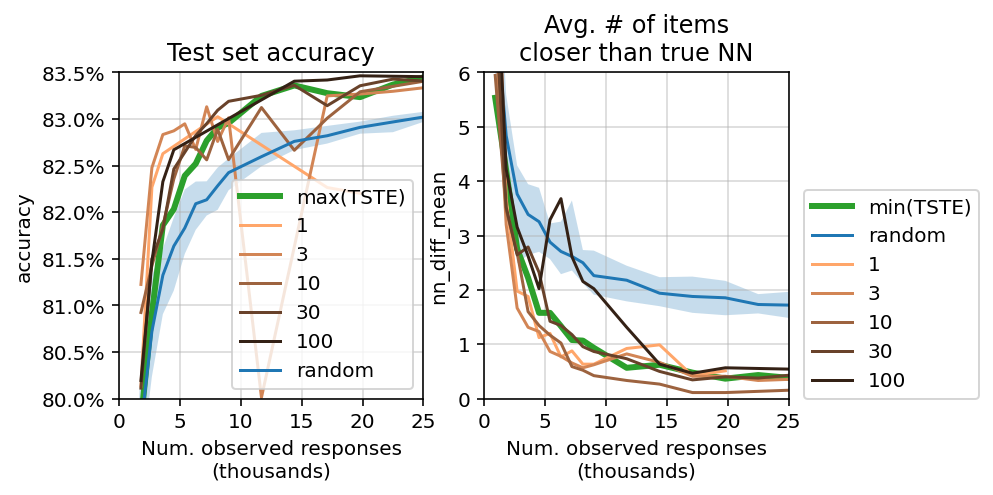

In [14]:
show = active[(active.meta__search == "arr") & (active.meta__n_search == 90 * 44 * 89)].copy()
show["meta__n_top__str"] = show["meta__n_top"].astype(str)
print(len(show))

w = 3
fig, axs = plt.subplots(figsize=(2 * w, w), ncols=2)
searches = [1, 3, 10, 30, 100, 300, 1000]
# searches = [1, 3, 30, 300, 1000]
# searches = [3, 30, 100, 300]
# searches = [1, 10, 100, 1000]
# searches = [1, 3, 10, 30, 100]#, 100, 300, 1000]
searches = [1, 3, 10, 30, 100]#, 1000]#, 300, 1000]
kwargs = dict(
    x="meta__len_X_train",
    hue="meta__n_top__str",
    hue_order=list(map(str, searches)),
    palette="copper_r",
    ci=None,
)
_plot_tste_perf(SALMON_TSTE, axs[0], y="accuracy")
ax = sns.lineplot(data=show[show.accuracy >= 0.80], y="accuracy", ax=axs[0], **kwargs)
_plot_perf(random, ax, kwargs, y="accuracy")
# ax.legend_.remove()

# idx = (active.meta__n_top == 1) & (active.meta__search == "arr")
# print(idx.sum())
# print(show.meta__search.unique())
# sns.lineplot(
#     data=active[idx], y="accuracy", ax=ax, x="meta__len_X_train",
#     estimator="max", ci=None,
#     linewidth=3, label="max(ARR)",
# )

_plot_tste_perf(SALMON_TSTE, axs[1], y="nn_diff_mean")
_plot_perf(random, axs[1], kwargs, y="nn_diff_mean")
ax = sns.lineplot(data=show, y="nn_diff_mean", ax=axs[1], **kwargs)
# print(idx.sum())
# print(show.meta__search.unique())
# sns.lineplot(
#     data=active[idx], y="accuracy", ax=ax, x="meta__len_X_train",
#     estimator="min", ci=None,
#     linewidth=3, label="min(ARR)",
# )
ax.legend(loc=(1.05, 0))
_fmt(axs)
# for ax in axs:
#     ax.set_xlim(0, 15_000)
fig.savefig("figs3/arr-n_top.png", **save_kwargs)

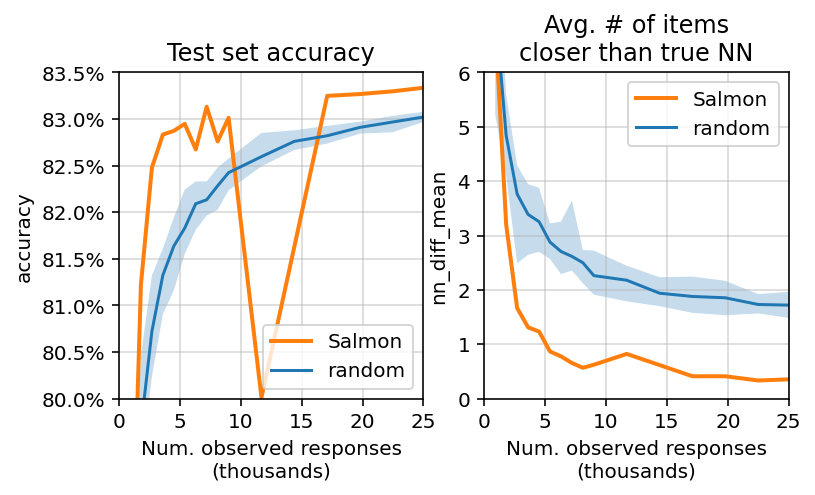

In [15]:
w = 3
fig, axs = plt.subplots(ncols=2, figsize=(2 * w, w))

kwargs = dict(
    x="meta__len_X_train",
    ci=None,
)

# idx = (show.accuracy >= 0.80) & (show.meta__n_top == 3)
idx = show.meta__n_top == 3
bad = (14_000 <= show.meta__len_X_train) & (show.meta__len_X_train <= 15_000)
s = show[idx & (~bad)].copy()

ax = sns.lineplot(
    data=s,
    y="accuracy",
    ax=axs[0], 
    label="Salmon",
    color="C1",
    linewidth=2,
    **kwargs,
)
# _plot_tste_perf(SALMON_TSTE, axs[0], y="accuracy", linewidth=2, label="Best NEXT proxy")
_plot_perf(random, ax, kwargs, y="accuracy")

ax = sns.lineplot(
    data=s,
    y="nn_diff_mean",
    ax=axs[1],
    label="Salmon",
    linewidth=2,
    color="C1",
    **kwargs,
)
# _plot_tste_perf(SALMON_TSTE, axs[1], y="nn_diff_mean", linewidth=2, label="Best NEXT proxy")
_plot_perf(random, ax, kwargs, y="nn_diff_mean")

_fmt(axs)
fig.savefig("figs3/summary.png", **save_kwargs)


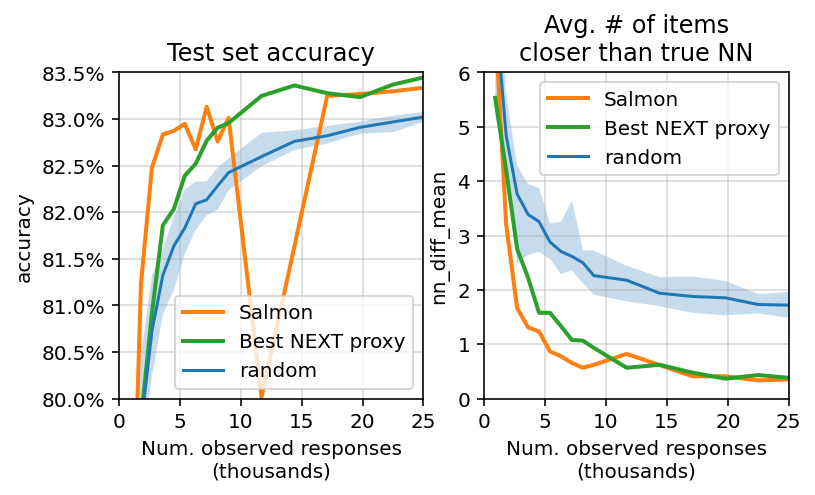

In [16]:
w = 3
fig, axs = plt.subplots(ncols=2, figsize=(2 * w, w))

kwargs = dict(
    x="meta__len_X_train",
    ci=None,
)

# idx = (show.accuracy >= 0.80) & (show.meta__n_top == 3)
idx = show.meta__n_top == 3
bad = (14_000 <= show.meta__len_X_train) & (show.meta__len_X_train <= 15_000)
s = show[idx & (~bad)]

ax = sns.lineplot(
    data=s,
    y="accuracy",
    ax=axs[0], 
    label="Salmon",
    color="C1",
    linewidth=2,
    **kwargs,
)
_plot_tste_perf(SALMON_TSTE, axs[0], y="accuracy", linewidth=2, label="Best NEXT proxy")
_plot_perf(random, ax, kwargs, y="accuracy")

ax = sns.lineplot(
    data=s,
    y="nn_diff_mean",
    ax=axs[1],
    label="Salmon",
    linewidth=2,
    color="C1",
    **kwargs,
)
_plot_tste_perf(SALMON_TSTE, axs[1], y="nn_diff_mean", linewidth=2, label="Best NEXT proxy")
_plot_perf(random, ax, kwargs, y="nn_diff_mean")

_fmt(axs)
fig.savefig("figs3/summary-complete.png", **save_kwargs)


In [17]:
df.columns

Index(['Unnamed: 0', 'accuracy', 'nn_diff_median', 'nn_diff_mean', 'nn_acc',
       'avg_items_closer_than_NN', 'nn_diff_p99', 'nn_diff_p98', 'nn_diff_p95',
       'nn_diff_p90', 'nn_diff_p80', 'nn_diff_p70', 'nn_diff_p60',
       'nn_diff_p50', 'nn_diff_p40', 'nn_diff_p30', 'nn_diff_p20',
       'nn_diff_p10', 'nn_diff_p5', 'nn_diff_p2', 'nn_diff_p1',
       'embedding_error', 'embedding_rel_error', 'procrustes_disparity',
       'nn_acc_radius_0', 'nn_acc_radius_1', 'nn_acc_radius_2',
       'nn_acc_radius_3', 'nn_acc_radius_4', 'nn_acc_radius_5',
       'nn_acc_radius_6', 'nn_acc_radius_7', 'nn_acc_radius_8',
       'nn_acc_radius_9', 'nn_acc_radius_10', 'nn_acc_radius_11',
       'nn_acc_radius_12', 'nn_acc_radius_13', 'nn_acc_radius_14',
       'nn_acc_radius_15', 'nn_acc_radius_16', 'nn_acc_radius_17',
       'nn_acc_radius_18', 'nn_acc_radius_19', 'nn_acc_radius_20',
       'nn_acc_radius_21', 'nn_acc_radius_22', 'nn_acc_radius_23',
       'nn_acc_radius_24', 'nn_acc_radius_25',

In [18]:
max_search = 89 * 88 // 2

nm = "CKL"
for n_top, num_ans, n_search in [
    (30, 900, max_search),
    (300, 900, max_search),
    (1, 900, 30_000),
]:
    idx = (active.meta__n_search == n_search) & (active.meta__n_top == n_top) & (active.meta__num_ans == num_ans)
    idx &= active.meta__noise_model == nm
    assert idx.sum() == 0, idx.sum()

AssertionError: 1

In [19]:
n_top, num_ans, n_search

(1, 900, 30000)

In [20]:
active[idx].iloc[0].to_dict()

{'Unnamed: 0': 1399,
 'accuracy': 0.7335011185682326,
 'nn_diff_median': 6.0,
 'nn_diff_mean': 7.4,
 'nn_acc': 0.0444444444444444,
 'avg_items_closer_than_NN': 15.9,
 'nn_diff_p99': 19.22,
 'nn_diff_p98': 19.0,
 'nn_diff_p95': 16.549999999999997,
 'nn_diff_p90': 15.100000000000009,
 'nn_diff_p80': 12.0,
 'nn_diff_p70': 9.0,
 'nn_diff_p60': 7.399999999999999,
 'nn_diff_p50': 6.0,
 'nn_diff_p40': 5.0,
 'nn_diff_p30': 4.0,
 'nn_diff_p20': 4.0,
 'nn_diff_p10': 2.0,
 'nn_diff_p5': 1.0,
 'nn_diff_p2': 0.0,
 'nn_diff_p1': 0.0,
 'embedding_error': 0.3232508604116811,
 'embedding_rel_error': 0.3232508604116811,
 'procrustes_disparity': 0.1044911187568921,
 'nn_acc_radius_0': 0.0444444444444444,
 'nn_acc_radius_1': 0.0666666666666666,
 'nn_acc_radius_2': 0.1222222222222222,
 'nn_acc_radius_3': 0.1888888888888888,
 'nn_acc_radius_4': 0.3333333333333333,
 'nn_acc_radius_5': 0.4666666666666667,
 'nn_acc_radius_6': 0.5444444444444444,
 'nn_acc_radius_7': 0.6,
 'nn_acc_radius_8': 0.6888888888888889,


In [21]:
len(df)

648

In [22]:
df["meta__meta__fname"].tolist()

[nan,
 nan,
 'salmon/io/2021-05-26-search/TSTE-n_search=30-1_responses.csv.zip',
 'salmon/io/2021-05-26-search/TSTE-n_search=3000-1_responses.csv.zip',
 'salmon/io/2021-05-26-search/TSTE-n_search=300000-1_responses.csv.zip',
 nan,
 'salmon/io/2021-05-26-search/TSTE-n_search=30-1_responses.csv.zip',
 nan,
 'salmon/io/2021-05-26-search/TSTE-n_search=3000-1_responses.csv.zip',
 'salmon/io/2021-05-26-search/TSTE-n_search=300-1_responses.csv.zip',
 'salmon/io/2021-05-26-search/TSTE-n_search=30000-1_responses.csv.zip',
 'salmon/io/2021-05-26-search/TSTE-n_search=3000-1_responses.csv.zip',
 'salmon/io/2021-05-26-search/TSTE-n_search=30-1_responses.csv.zip',
 'salmon/io/2021-05-26-search/TSTE-n_search=300000-1_responses.csv.zip',
 'salmon/io/2021-05-26-search/TSTE-n_search=300-1_responses.csv.zip',
 'salmon/io/2021-05-26-search/TSTE-n_search=30000-1_responses.csv.zip',
 'salmon/io/2021-05-26-search/TSTE-n_search=300000-1_responses.csv.zip',
 'salmon/io/2021-05-26-search/TSTE-n_search=3000-1_re